In [262]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as scs

In [309]:
#Paramètres
 #paramètres des données
n = 1000

p = 1/2
mu = np.array([0,0])
L = np.random.randn(2,2)
Sigma = L.transpose() @ L
w = 2*np.random.rand(2)
W = np.array([w for _ in range(n)])

 #paramètres de la régression
Lambd = [1,0.5,0]
Gamma = [0,0.1,1,10,100,1000]

sigma = 1

In [310]:
#Data
S = np.array([np.random.choice([0,1],p = [1/2,1/2]) for _ in range(n)])
X = np.array([S,np.zeros(n)]).transpose() + np.array([scs.multivariate_normal.rvs(mu,Sigma) for _ in range(n)])

Z = np.concatenate([np.reshape(X,(n,2)),np.reshape(S,(n,1))],axis = 1)


#Theta = theta_0 + S.reshape(n,1) @ (theta_1 - theta_0).reshape(1,2)
Eps = np.random.randn(n)
Y = np.cos(np.vdot(X,W) + 1.5*S) + 4*S + Eps

(-6.0, 7.0, 0.0, 100.0)

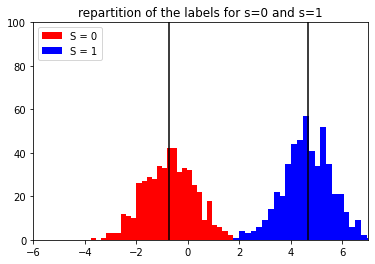

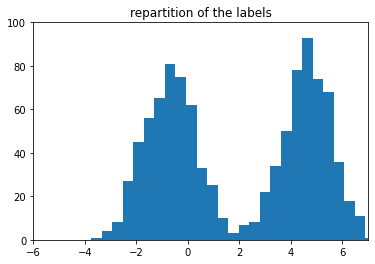

In [311]:
#Plot 
Y_0 = [Y[i]  for i in range(n) if S[i] == 0]
Y_1 = [Y[i]  for i in range(n) if S[i] == 1]
plt.hist(Y_0,color ="red",bins=30,label = "S = 0")
plt.hist(Y_1,color ="blue",bins=30,label = "S = 1")
plt.plot([np.mean(Y_0),np.mean(Y_0)],[0,500],"black")
plt.plot([np.mean(Y_1),np.mean(Y_1)],[0,500],"black")
plt.legend()
plt.axis([-6,7,0,100])
plt.title("repartition of the labels for s=0 and s=1" )

plt.figure()
plt.hist(Y,bins = 30)
plt.title("repartition of the labels")
plt.axis([-6,7,0,100])

In [312]:
#Kernels
def k(s1,s2):
    return int(s1 == s2)

def g(x1,x2,sigma):
    return np.exp(-np.linalg.norm(x1 - x2)**2 / (2*sigma))

def m(z1,z2,sigma):
    s1,s2 = z1[2],z2[2]
    x1,x2 = z1[:2],z2[:2] 
    return k(s1,s2) * g(x1,x2,sigma)

In [313]:
def K_mat(S):
    S1 = S.reshape(n,1) * np.ones(n)
    S2 = S.reshape(1,n) * np.ones(n).reshape(n,1)
    return  1 + 2 * (S1*S2) - (S1 + S2)
    
    
def M_mat(X,K,sigma):
    Diff = X.reshape(n,1,2) - X.reshape(1,n,2)
    G = np.exp(-np.linalg.norm(Diff,axis = 2)**2 / (2*sigma))
    return G * K
    


In [314]:
#Matrices

I = np.identity(n)
H = I - 1/n * np.ones(n)

K = K_mat(S)
M = M_mat(X,K,sigma)

B = H @ K @ H 
C = M @ B @ M



In [315]:
def A_f(lambd,gamma):
    return lambd * (n**2) * M +  n* M @ M + gamma * C



In [316]:
def f_reg(alpha,T):
    return np.dot(alpha,T) #np.array([m(z,Z[i],sigma) for i in range(n)])

def HSIC_f(Pred):
    return Pred.reshape(1,n) @ B @ Pred.reshape(n,1)

def Loss_f(Y_test,Y_pred):
    return np.mean((Y_test - Y_pred)**2)

def Av_dif_f(Pred,S_test):
    Pred_0 = np.array([Pred[i]  for i in range(n) if S_test[i] == 0])
    Pred_1 = np.array([Pred[i]  for i in range(n) if S_test[i] == 1])
    return np.abs(np.mean(Pred_0) - np.mean(Pred_1))

In [317]:
#Test  data

S_t = np.array([np.random.choice([0,1],p = [1/2,1/2]) for _ in range(n)])
X_t = np.array([S_t,np.zeros(n)]).transpose() + np.array([scs.multivariate_normal.rvs(mu,Sigma) for _ in range(n)])

Z_t = np.concatenate([np.reshape(X_t,(n,2)),np.reshape(S_t,(n,1))],axis = 1)


#Theta = theta_0 + S.reshape(n,1) @ (theta_1 - theta_0).reshape(1,2)
Eps_t = np.random.randn(n)
Y_t = np.cos(np.vdot(X_t,W) + 1.5*S_t) + 4*S_t + Eps_t

(-3.0, 6.0, 0.0, 100.0)

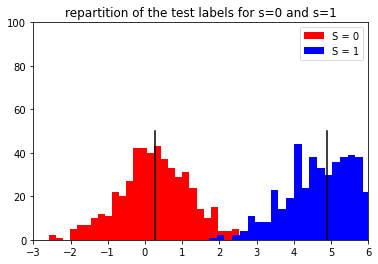

In [318]:
#Plot test data
Y_0_test = [Y_t[i]  for i in range(n) if S_t[i] == 0]
Y_1_test = [Y_t[i]  for i in range(n) if S_t[i] == 1]
plt.hist(Y_0_test,color ="red",bins=30,label = "S = 0")
plt.hist(Y_1_test,color ="blue",bins=30,label = "S = 1")
plt.plot([np.mean(Y_0_test),np.mean(Y_0_test)],[0,50],"black")
plt.plot([np.mean(Y_1_test),np.mean(Y_1_test)],[0,50],"black")
plt.legend()
plt.title("repartition of the test labels for s=0 and s=1" )
plt.axis([-3,6,0,n/10])

In [319]:
T = np.array([[m(Z_t[k],Z[l],sigma) for l in range(n)] for k in range(n)])

In [320]:
Loss = np.zeros((len(Lambd),len(Gamma)))
Av_dif = np.zeros((len(Lambd),len(Gamma)))
HSIC = np.zeros((len(Lambd),len(Gamma)))

AA = np.array([[A_f(Lambd[i],Gamma[j]) for j in range(len(Gamma))] for i in range(len(Lambd))])
print(AA.shape)
AAA = np.array([[np.linalg.pinv(AA[i][j]) for j in range(len(Gamma))] for i in range(len(Lambd))])
Alpha = np.array([[n * AAA[i][j] @ M @ Y for j in range(len(Gamma))] for i in range(len(Lambd))])
Pred = np.array([[T @ Alpha[i][j] for j in range(len(Gamma))] for i in range(len(Lambd))])


(3, 6, 1000, 1000)


0
1
2
3
4
5
4
5
6
7
8
9
8
9
10
11
12
13


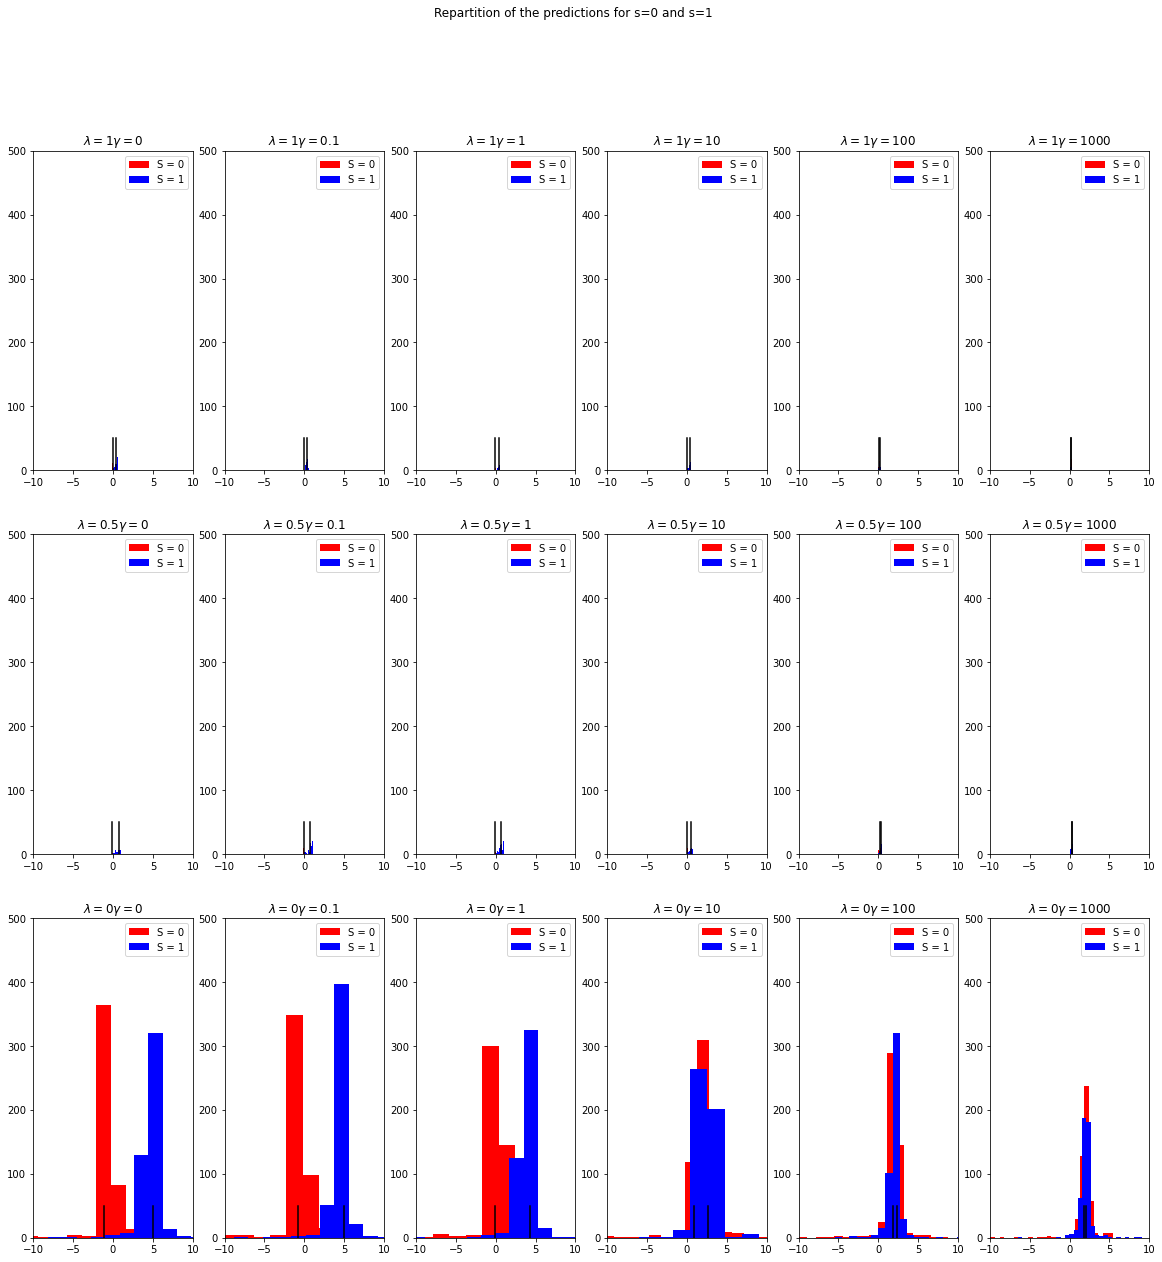

In [321]:
fig, axs = plt.subplots(len(Lambd), len(Gamma), figsize=(20,20))
for i in range(len(Lambd)):
    for j in range(len(Gamma)):
        Loss[i][j] = Loss_f(Pred[i][j],Y_t)
        HSIC[i][j] = HSIC_f(Pred[i][j])
        Av_dif[i][j] = Av_dif_f(Pred[i][j],S_t)
        Y_0_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 0]
        Y_1_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 1]
        axs[i,j].hist(Y_0_pred,color ="red",bins=60,label = "S = 0")
        axs[i,j].hist(Y_1_pred,color ="blue",bins=60,label = "S = 1")
        axs[i,j].plot([np.mean(Y_0_pred),np.mean(Y_0_pred)],[0,50],"black")
        axs[i,j].plot([np.mean(Y_1_pred),np.mean(Y_1_pred)],[0,50],"black")
        axs[i,j].legend()
        axs[i,j].set_title(r"$\lambda = $" + str(Lambd[i]) + r"$\gamma = $" + str(Gamma[j]))
        axs[i,j].axis([-10,10,0,500])
        print(4*i + j)

fig.suptitle('Repartition of the predictions for s=0 and s=1')

plt.show()

8
9
10
11
12
13


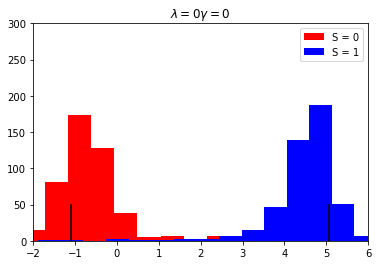

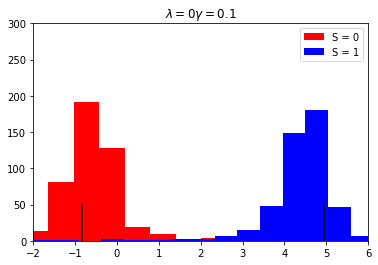

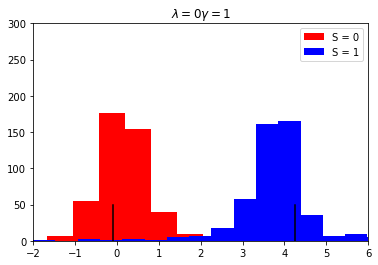

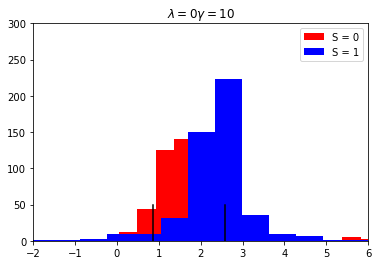

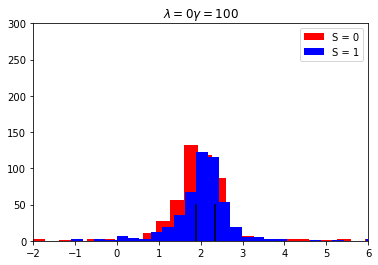

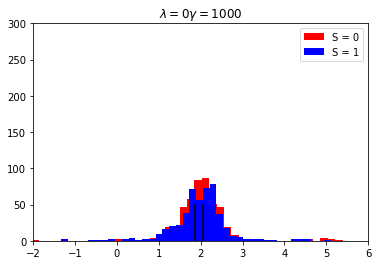

In [322]:

for i in range(len(Lambd)-1,len(Lambd)):
    for j in range(len(Gamma)):
        Loss[i][j] = Loss_f(Pred[i][j],Y_t)
        HSIC[i][j] = HSIC_f(Pred[i][j])
        Av_dif[i][j] = Av_dif_f(Pred[i][j],S_t)
        Y_0_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 0]
        Y_1_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 1]
        plt.figure()
        plt.hist(Y_0_pred,color ="red",bins=200,label = "S = 0")
        plt.hist(Y_1_pred,color ="blue",bins=200,label = "S = 1")
        plt.plot([np.mean(Y_0_pred),np.mean(Y_0_pred)],[0,50],"black")
        plt.plot([np.mean(Y_1_pred),np.mean(Y_1_pred)],[0,50],"black")
        plt.legend()
        plt.title(r"$\lambda = $" + str(Lambd[i]) + r"$\gamma = $" + str(Gamma[j]))
        plt.axis([-2,6,0,300])
        print(4*i + j)

fig.suptitle('Repartition of the predictions for s=0 and s=1')

plt.show()

4
5
6
7
8
9


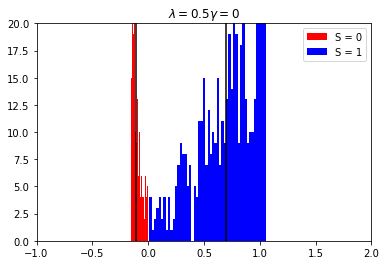

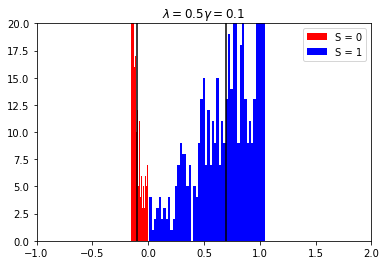

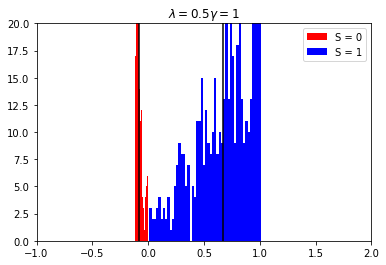

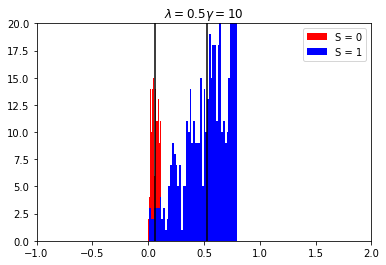

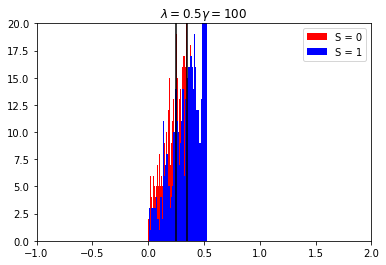

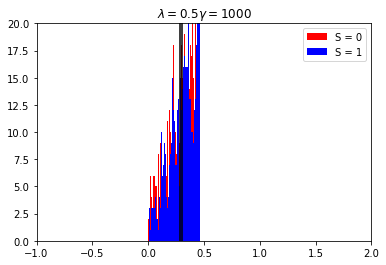

In [323]:
for i in range(len(Lambd)-2,len(Lambd)-1):
    for j in range(len(Gamma)):
        Loss[i][j] = Loss_f(Pred[i][j],Y_t)
        HSIC[i][j] = HSIC_f(Pred[i][j])
        Av_dif[i][j] = Av_dif_f(Pred[i][j],S_t)
        Y_0_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 0]
        Y_1_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 1]
        plt.figure()
        plt.hist(Y_0_pred,color ="red",bins=50,label = "S = 0")
        plt.hist(Y_1_pred,color ="blue",bins=50,label = "S = 1")
        plt.plot([np.mean(Y_0_pred),np.mean(Y_0_pred)],[0,50],"black")
        plt.plot([np.mean(Y_1_pred),np.mean(Y_1_pred)],[0,50],"black")
        plt.legend()
        plt.title(r"$\lambda = $" + str(Lambd[i]) + r"$\gamma = $" + str(Gamma[j]))
        plt.axis([-1,2,0,20])
        print(4*i + j)

fig.suptitle('Repartition of the predictions for s=0 and s=1')

plt.show()

0
1
2
3
4
5


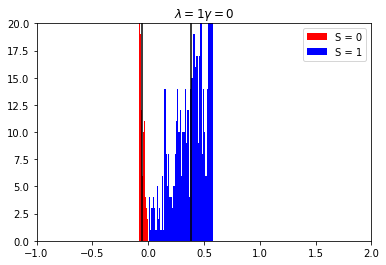

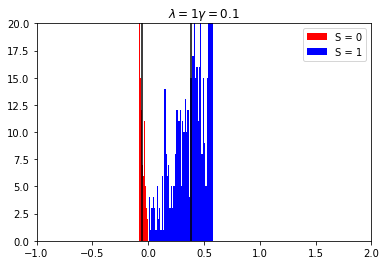

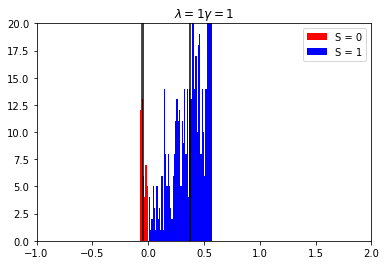

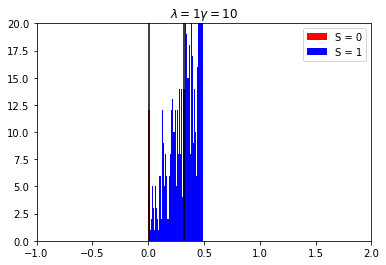

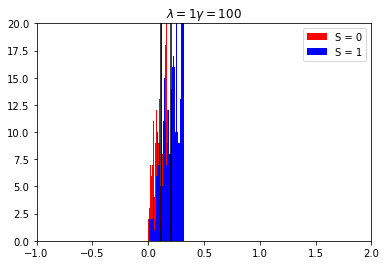

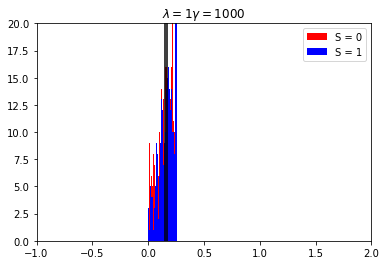

In [324]:
for i in range(len(Lambd)-3,len(Lambd)-2):
    for j in range(len(Gamma)):
        Loss[i][j] = Loss_f(Pred[i][j],Y_t)
        HSIC[i][j] = HSIC_f(Pred[i][j])
        Av_dif[i][j] = Av_dif_f(Pred[i][j],S_t)
        Y_0_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 0]
        Y_1_pred = [Pred[i][j][k]  for k in range(n) if S_t[k] == 1]
        plt.figure()
        plt.hist(Y_0_pred,color ="red",bins=50,label = "S = 0")
        plt.hist(Y_1_pred,color ="blue",bins=50,label = "S = 1")
        plt.plot([np.mean(Y_0_pred),np.mean(Y_0_pred)],[0,50],"black")
        plt.plot([np.mean(Y_1_pred),np.mean(Y_1_pred)],[0,50],"black")
        plt.legend()
        plt.title(r"$\lambda = $" + str(Lambd[i]) + r"$\gamma = $" + str(Gamma[j]))
        plt.axis([-1,2,0,20])
        print(4*i + j)

fig.suptitle('Repartition of the predictions for s=0 and s=1')

plt.show()

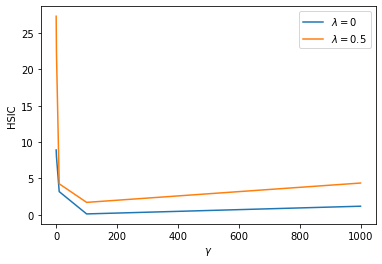

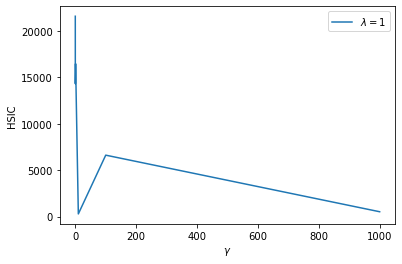

In [325]:
plt.plot(Gamma,HSIC[0,:], label = r"$\lambda =$" + str(0))
plt.plot(Gamma,HSIC[1,:], label = r"$\lambda =$" + str(0.5))
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel("HSIC")
plt.figure()



plt.plot(Gamma,HSIC[2,:], label = r"$\lambda =$" + str(1))
plt.xlabel(r"$\gamma$")
plt.ylabel("HSIC")
plt.legend()


<Figure size 432x288 with 0 Axes>

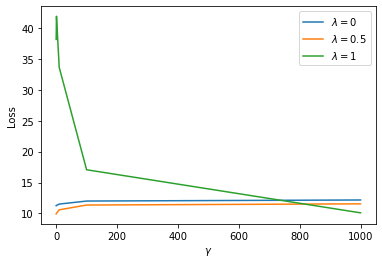

<Figure size 432x288 with 0 Axes>

In [326]:
plt.plot(Gamma,Loss[0,:], label = r"$\lambda =$" + str(0))
plt.plot(Gamma,Loss[1,:], label = r"$\lambda =$" + str(0.5))
plt.plot(Gamma,Loss[2,:], label = r"$\lambda =$" + str(1))
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel("Loss")
plt.figure()


<Figure size 432x288 with 0 Axes>

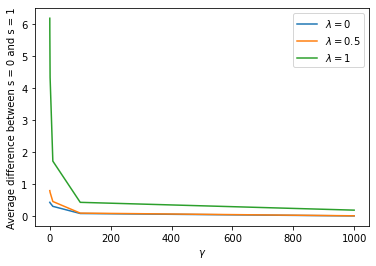

<Figure size 432x288 with 0 Axes>

In [327]:
plt.plot(Gamma,Av_dif[0,:], label = r"$\lambda =$" + str(0))
plt.plot(Gamma,Av_dif[1,:], label = r"$\lambda =$" + str(0.5))
plt.plot(Gamma,Av_dif[2,:], label = r"$\lambda =$" + str(1))
plt.legend()
plt.xlabel(r"$\gamma$")
plt.ylabel("Average difference between s = 0 and s = 1")
plt.figure()
